# Assignment 2 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Markdown, display
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [5, 3]

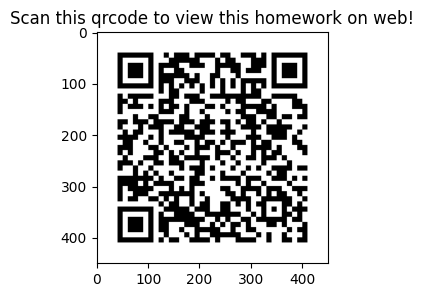

In [3]:
import qrcode
url = "https://algebra-fun.github.io/DDM-Coursework/MSDM5053/Homework/hw2/"
plt.imshow(qrcode.make(url), cmap='gray')
plt.title("Scan this qrcode to view this homework on web!")
plt.show()

## 1. Consider the conventional 30-year mortgage rate of U.S. 

from June 1976 to March 2007. 

The data are obtained from Federal Reserve Bank at St Louis. 

1. Take the natural log transformation of the mortgage rate to build a time series model for the series. 
2. Perform model checking using Q(12) for residuals. (all tests are based on the 5% significance level) 
3. Write down the fitted model. 
4. Use the fitted model to produce 1-step to 4-step ahead forecasts at the forecast origin March, 2007. 

In [2]:
mortg = pd.read_csv("data/m-mortg.csv", index_col=0, parse_dates=True)
mortg

,rate
date,
1976-06-01,8.85
1976-07-01,8.93
1976-08-01,9.00
1976-09-01,8.98
1976-10-01,8.93
...,...
2006-11-01,6.24
2006-12-01,6.14
2007-01-01,6.22


In [3]:
# 1. Take the natural log transformation of the mortgage rate to build a time series model for the series.
mortg["log_rate"] = mortg["rate"].apply(np.log)
mortg

,rate,log_rate
date,,
1976-06-01,8.85,2.180417
1976-07-01,8.93,2.189416
1976-08-01,9.00,2.197225
1976-09-01,8.98,2.195000
1976-10-01,8.93,2.189416
...,...,...
2006-11-01,6.24,1.830980
2006-12-01,6.14,1.814825
2007-01-01,6.22,1.827770


In [4]:
def plot_acf_pacf(series, lags=12):
    fig, (ax1,ax2) = plt.subplots(1,2)

    tsaplots.plot_acf(series, lags=lags,ax=ax1)
    ax1.set_xlabel("lags")
    ax1.set_ylabel("acf")
    ax1.grid("True")

    tsaplots.plot_pacf(series, lags=lags,ax=ax2)
    ax2.set_xlabel("lags")
    ax2.set_ylabel("pacf")
    ax2.grid("True")

    fig.tight_layout()

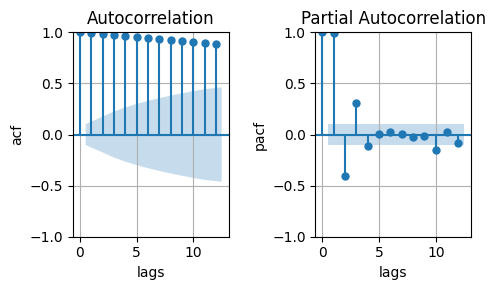

In [5]:
plot_acf_pacf(mortg["log_rate"],lags=12)
plt.show()

From the plot of acf and pacf, we can see pacfs are significant when lag $\tau \leq 2$, while acfs aren't 0 and decay, which indicates an `AR(2)` model.

In [6]:
# build an ARIMA model by grid search
ps = range(4)
ds = range(3)
qs = range(4)
best_aic = np.inf
for p,d,q in product(ps,ds,qs):
    try:
        mod = ARIMA(mortg.log_rate, order=(p,d,q),dates=mortg.index).fit()
        if mod.aic < best_aic:
            best_aic = mod.aic
            best_mod = mod
            print(f"current selection: ARIMA{(p,d,q)}, AIC={best_aic:.2f}") 
    except:
        continue

mortg_mod = best_mod
mortg_mod.summary()

current selection: ARIMA(0, 0, 0), AIC=146.12
current selection: ARIMA(0, 0, 1), AIC=-338.81
current selection: ARIMA(0, 0, 2), AIC=-726.39
current selection: ARIMA(0, 0, 3), AIC=-983.87
current selection: ARIMA(0, 1, 0), AIC=-1541.29
current selection: ARIMA(0, 1, 1), AIC=-1630.03
current selection: ARIMA(0, 1, 3), AIC=-1632.85
current selection: ARIMA(3, 1, 0), AIC=-1633.45


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               log_rate   No. Observations:                  370
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 820.726
Date:                Sat, 25 Mar 2023   AIC                          -1633.453
Time:                        12:09:51   BIC                          -1617.810
Sample:                    06-01-1976   HQIC                         -1627.239
                         - 03-01-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5323      0.049     10.758      0.000       0.435       0.629
ar.L2         -0.3491      0.041     -8.560      0.000      -0.429      -0.269
ar.L3          0.0894      0.054      1.654      0.098      -0.017       0.195
sigma2         0.0007   3.12e-05     21.949      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               281.52
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.67
Prob(H) (two-sided):                  0.64   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
np.diff(mortg_mod.data.endog,n=1).mean()

-0.000981953066326313

In [56]:
# 2. Perform model checking using Q(12) for residuals.
Q12 = acorr_ljungbox(mortg_mod.resid, model_df=mortg_mod.df_model-1,lags=[12], return_df=True)
display(Q12)
Markdown(rf"""
The p-value for the Ljung-Box test is {Q12.lb_pvalue.item():.4f}, which is greater than $\alpha=0.05$, 
so we failed to reject the null hypothesis that the residuals are uncorrelated. 
""")

,lb_stat,lb_pvalue
12,0.05655,1.0



The p-value for the Ljung-Box test is 1.0000, which is greater than $\alpha=0.05$, 
so we failed to reject the null hypothesis that the residuals are uncorrelated. 


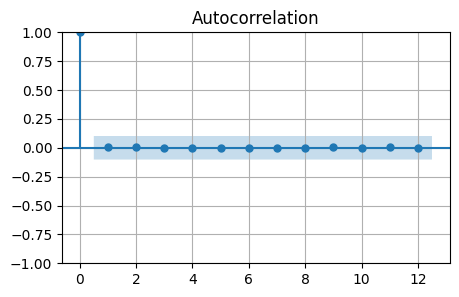

In [8]:
tsaplots.plot_acf(mortg_mod.resid,lags=12)
plt.grid(True)
plt.show()

In [44]:
# 3. Write down the fitted model. 
mu = np.diff(mortg_mod.data.endog,n=1).mean()
intercept = mortg_mod.polynomial_ar.sum()*mu
intercept

-0.000714260353130526

#### (3) Write down the fitted model. 

**ARIMA(3,1,0)**:

$$
(1-0.53232078B+0.34909144B^2-0.0893832B^3)(1-B)r_t=-0.000714260353130526+a_t,\quad \hat{\sigma_a^2}=0.0007
$$

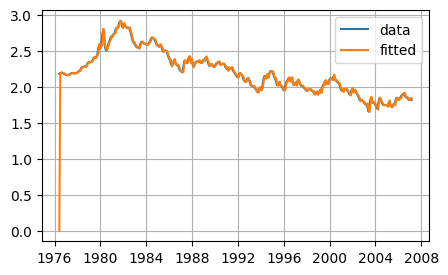

In [9]:
plt.plot(mortg.log_rate,label="data")
plt.plot(mortg_mod.fittedvalues,label="fitted")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# 4. Use the fitted model to produce 1-step to 4-step ahead forecasts at the forecast origin March, 2007. 
mortg_mod.forecast(steps=4)

2007-04-01    1.804210
2007-05-01    1.805119
2007-06-01    1.808577
2007-07-01    1.808861
Freq: MS, Name: predicted_mean, dtype: float64

## 2.Recall the monthly simple returns of the Decile 1 portfolio from January 1980 to December 2006. 

1. Use seasonal model to analyze the Deceile 1 returns. The model is a multiplicative seasonal model as ARIMA(0,0,1)(1,0,1) with period 12. 
2. Perform model checking on the fitted model, e.g., compute Q(24) of the residuals. Is the model adequate? (all tests are based on the 5% significance level)
3. Write down the fitted model. 

In [11]:
dec1 = pd.read_csv("data/m-dec1-8006.csv", index_col=0, parse_dates=True,
                   date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d"))
dec1

,return
date,
1980-01-31,0.18668
1980-02-29,0.02908
1980-03-31,-0.16778
1980-04-30,0.00772
1980-05-30,0.04802
...,...
2006-08-31,-0.00685
2006-09-29,0.00628
2006-10-31,0.03864


In [12]:
# 1. build ARIMA(0,0,1)(1,0,1) with period 12.
dec1_mod = ARIMA(dec1['return'], order=(0,0,1), seasonal_order=(1,0,1,12)).fit()
dec1_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           return   No. Observations:                  324
Model:             ARIMA(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 420.447
Date:                          Sat, 25 Mar 2023   AIC                           -830.894
Time:                                  12:09:51   BIC                           -811.990
Sample:                                       0   HQIC                          -823.348
                                          - 324                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0183      0.014      1.313      0.189      -0.009       0.046
ma.L1          0.2438      0.035      7.011      0.000       0.176       0.312
ar.S.L12       0.9998      0.014     74.032      0.000       0.973       1.026
ma.S.L12      -0.9888      0.363     -2.724      0.006      -1.700      -0.277
sigma2         0.0041      0.001      3.147      0.002       0.002       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1105.75
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

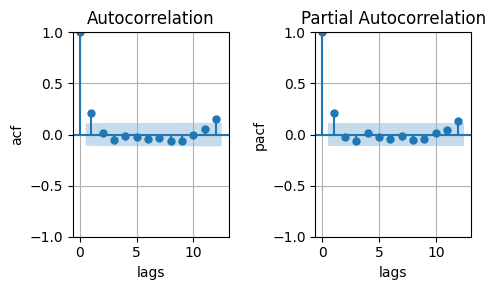

In [13]:
plot_acf_pacf(dec1['return'],lags=12)

In [57]:
# 2. Perform model checking on the fitted model, e.g., compute Q(24) of the residuals.
Q24 = acorr_ljungbox(dec1_mod.resid, model_df=dec1_mod.df_model-2, lags=[24], return_df=True)
display(Q24)
Markdown(rf"""
The p-value for the Ljung-Box test is {Q24.lb_pvalue.item():.4f}, which is bigger than $\alpha=0.05$, so we fail to reject the null hypothesis that the residuals are uncorrelated.
Then this test result indicates that the model is adequate.
""")

,lb_stat,lb_pvalue
24,23.332411,0.326514



The p-value for the Ljung-Box test is 0.3265, which is bigger than $\alpha=0.05$, so we fail to reject the null hypothesis that the residuals are uncorrelated.
Then this test result indicates that the model is adequate.


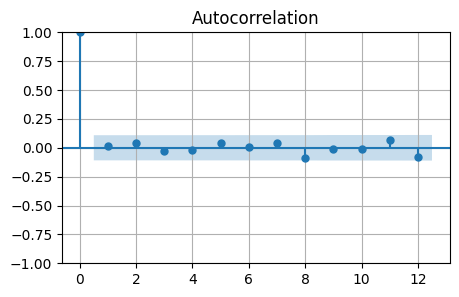

In [15]:
tsaplots.plot_acf(dec1_mod.resid,lags=12)
plt.grid(True)
plt.show()

From above plot, we can see the model fits not well. Thus, we claim this model isn't adequate.

In [48]:
### (3) Write down the fitted model.
mu = dec1_mod.data.endog.mean()
intercept = dec1_mod.polynomial_seasonal_ar.sum()*mu
intercept

3.7154408770671947e-06

#### (3) Write down the fitted model.

**SARIMA(1,0,0)x(1,0,1,12)**:

$$
(1-0.9998B^{12})r_t=3.7154e-6+(1-0.2438B)(1+0.9888B^{12})a_t,\quad\hat{\sigma_a}^2=0.0041
$$

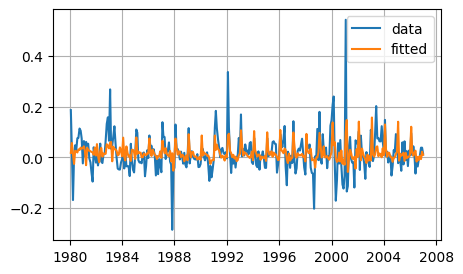

In [16]:
plt.plot(dec1.index, dec1['return'], label="data")
plt.plot(dec1.index, dec1_mod.fittedvalues, label="fitted")
plt.grid(True)
plt.legend()
plt.show()

# 3. Consider the quarterly earnings per share of the Alcoa stock 

from the 4th quarter of 1991 to the most recent quarter. Note that some earnings are negative. 
1. Build a model for the earning series. 
2. Perform model checking to ensure that the model is adequate using Q(12) of the residuals. 
3. Use the model to produce 1-step to 4-step ahead forecasts. (all tests are based on the 5% significance level)

In [17]:
qaaearn = pd.read_csv("data/q-aa-earn.csv", index_col=0, parse_dates=True,
                      date_parser=lambda x: pd.to_datetime(x, format="%d/%m/%Y"))
qaaearn

,earning
date,
1991-11-05,0.15
1992-01-16,-0.29
1992-04-10,0.08
1992-07-14,0.06
1992-10-12,0.07
...,...
2005-10-10,0.33
2006-01-09,0.35
2006-04-10,0.70


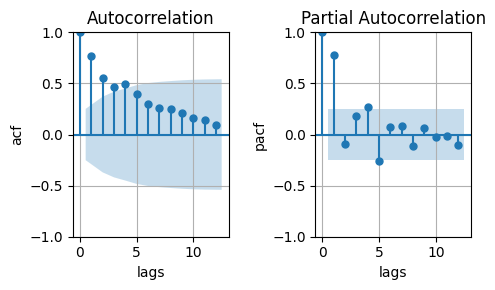

In [18]:
plot_acf_pacf(qaaearn["earning"],lags=12)

In [19]:
qs = range(3)
ps = range(2)
ds = range(2)
ss = [4,6,12]
best_aic = np.inf
for (p,d,q),(P,D,Q,s) in product(product(ps,ds,qs),product(ps,ds,qs,ss)):
    try:
        mod = ARIMA(qaaearn.earning, order=(p,d,q), seasonal_order=(P,D,Q,s)).fit()
        if mod.aic < best_aic:
            best_aic = mod.aic
            best_mod = mod
            print(f"current selection: ARIMA{(p,d,q)}x{(P,D,Q,s)}, AIC={best_aic:.2f}") 
    except:
        continue

earn_mod = best_mod
earn_mod.summary()

current selection: ARIMA(0, 0, 0)x(0, 0, 0, 4), AIC=-23.91
current selection: ARIMA(0, 0, 0)x(0, 0, 1, 4), AIC=-46.97
current selection: ARIMA(0, 0, 0)x(0, 0, 2, 4), AIC=-48.01
current selection: ARIMA(0, 0, 0)x(0, 1, 0, 4), AIC=-57.46
current selection: ARIMA(0, 0, 1)x(0, 0, 0, 4), AIC=-57.54
current selection: ARIMA(0, 0, 1)x(0, 0, 1, 4), AIC=-77.23
current selection: ARIMA(0, 0, 1)x(0, 0, 2, 4), AIC=-79.56
current selection: ARIMA(0, 0, 1)x(0, 1, 0, 4), AIC=-82.05
current selection: ARIMA(0, 0, 1)x(1, 0, 0, 4), AIC=-83.59
current selection: ARIMA(0, 0, 2)x(0, 0, 1, 4), AIC=-87.86
current selection: ARIMA(0, 0, 2)x(0, 0, 2, 4), AIC=-90.54
current selection: ARIMA(0, 0, 2)x(0, 1, 0, 4), AIC=-91.37
current selection: ARIMA(0, 0, 2)x(1, 0, 0, 4), AIC=-94.34
current selection: ARIMA(1, 0, 0)x(1, 0, 0, 4), AIC=-95.64


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         earning   No. Observations:                   61
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 4)   Log Likelihood                  51.819
Date:                         Sat, 25 Mar 2023   AIC                            -95.639
Time:                                 12:12:04   BIC                            -87.195
Sample:                                      0   HQIC                           -92.329
                                          - 61                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3204      0.143      2.246      0.025       0.041       0.600
ar.L1          0.7206      0.095      7.595      0.000       0.535       0.907
ar.S.L4        0.6993      0.082      8.533      0.000       0.539       0.860
sigma2         0.0101      0.001      8.513      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):                54.12
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                            -0.42
Prob(H) (two-sided):                  0.27   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
Q12 = acorr_ljungbox(earn_mod.resid, model_df=earn_mod.df_model-2,lags=[12], return_df=True)
display(Q12)
Markdown(rf"""
The p-value for the Ljung-Box test is {Q12.lb_pvalue.item():.4f}, which is bigger than $\alpha=0.05$, so we fail to reject the null hypothesis that the residuals are uncorrelated.
Then this test result indicates that the model is adequate.
""")

,lb_stat,lb_pvalue
12,4.903769,0.897513



The p-value for the Ljung-Box test is 0.8975, which is bigger than $\alpha=0.05$, so we fail to reject the null hypothesis that the residuals are uncorrelated.
Then this test result indicates that the model is adequate.


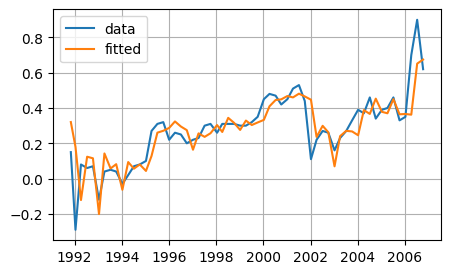

In [21]:
plt.plot(qaaearn.earning,label="data")
plt.plot(earn_mod.predict(),label="fitted")
plt.grid(True)
plt.legend()
plt.show()

In [22]:
# forecast 1-step to 4-step ahead
earn_mod.forecast(steps=4)

61    0.552168
62    0.737951
63    0.835315
64    0.608900
Name: predicted_mean, dtype: float64